In [1]:
# activate numpy and matplotlib functions
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
# Dynamically reload modules
%load_ext autoreload
%autoreload 2

In [3]:
# Figure width
fig_width=8

In [4]:
# Import our MW link processing package
import pycomlink as pycml

# Load data from IFU comlink database

In [5]:
from ifu_comlink_database.db_interface.expt import get_cml_data_from_IFU_database

In [6]:
cml_id = 'MY0364_2_MY2291_3'
cml = get_cml_data_from_IFU_database(cml_id, '2014-10-16', '2014-12-31')

# Print CML info

In [7]:
cml.info()

ID: MY0364_2_MY2291_3
-------------------------------------------------------------
     Site A                       Site B
 IP: 10.30.69.26                 10.30.69.20
  f:   --------- 19.15 GHz ---------- 
  f:   --------- 18.14 GHz ---------- 
  L: 10.926 km


# Plot TX-RX level

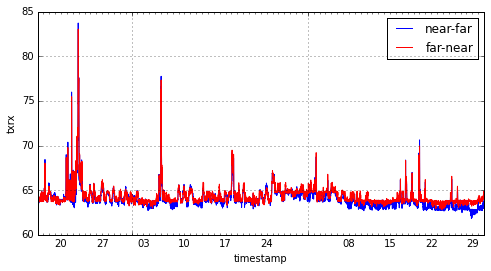

In [8]:
cml.plot('txrx', figsize=(fig_width,4), resampling_time='15min');

# Instead of getting data from data base, load from HDF5 file

In [9]:
cml = pycml.io.read_hdf5('example_data/one_TN_15_days.h5')

In [10]:
cml.info()

ID: MY0364_2_MY2291_3
-------------------------------------------------------------
     Site A                       Site B
 IP: 10.30.69.26                 10.30.69.20
  f:   --------- 18.14 GHz ---------- 
  f:   --------- 19.15 GHz ---------- 
  L: 10.926 km


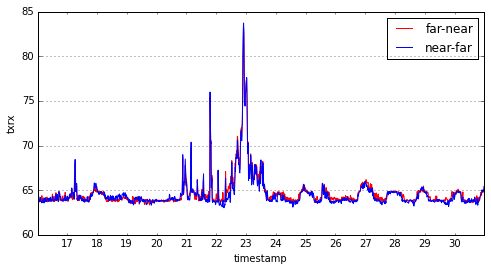

In [11]:
cml.plot('txrx', figsize=(fig_width,4), resampling_time='15min');

# Do wet/dry classification (using std_dev method, Schleiss et al, 2010)

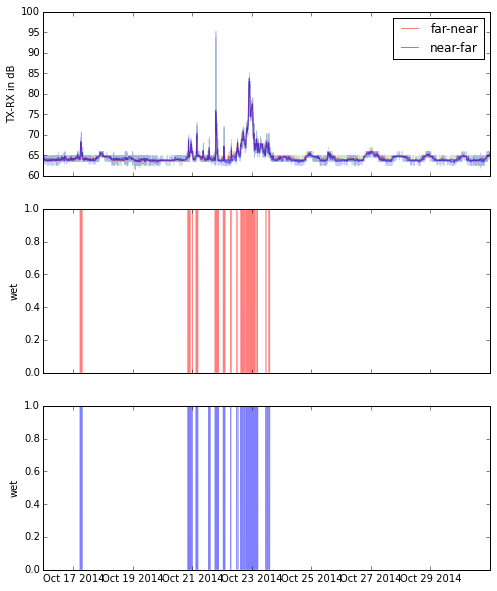

In [12]:
cml.do_wet_dry_classification(method='std_dev', window_length=128, threshold=1.1)

### PLOT ###
def plot_wet_dry():
    fig, ax = subplots(3, 1, figsize=(fig_width,10), sharex=True)
    ax[0].plot(cml.data.index, 
               cml.data.txrx_fn, alpha=0.2, color='g')
    ax[0].plot(cml.data.resample('15min').index, 
               cml.data.resample('15min').txrx_fn, alpha=0.5, color='r', label='far-near')
    ax[0].plot(cml.data.index, 
               cml.data.txrx_nf, alpha=0.2, color='b')
    ax[0].plot(cml.data.resample('15min').index, 
               cml.data.resample('15min').txrx_nf, alpha=0.5, color='b', label='near-far')
    ax[1].fill_between(cml.data.index, 
                       cml.data.wet_fn, lw=0.0, edgecolor=None, facecolor='r', alpha=0.5)
    ax[2].fill_between(cml.data.index, 
                       cml.data.wet_nf, lw=0.0, edgecolor=None, facecolor='b', alpha=0.5)

    ax[0].legend()
    ax[0].set_ylabel('TX-RX in dB')
    ax[1].set_ylabel('wet')
    ax[2].set_ylabel('wet');
plot_wet_dry()

# Do wet/dry classification (using stft method, Chwala et al, 2012)

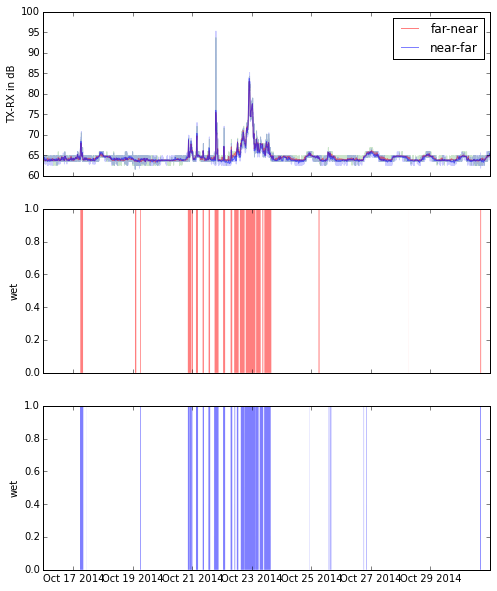

In [13]:
cml.do_wet_dry_classification(method='stft', window_length=128, f_divide=2e-3, threshold=5, dry_window_length=600)

plot_wet_dry()

# Combine wet(near-far) and wet(far-near)

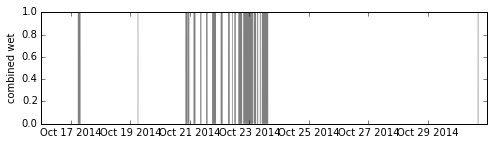

In [14]:
wet_combi = (cml.data.wet_fn & cml.data.wet_nf)

### PLOT ###
fig, ax = subplots(figsize=(fig_width,2))
ax.fill_between(wet_combi.index, wet_combi.values,
             lw=0.0, edgecolor=None, facecolor='k', alpha=0.5)
ax.set_ylabel('combined wet');

# Determin baseline and calculate the attenuation

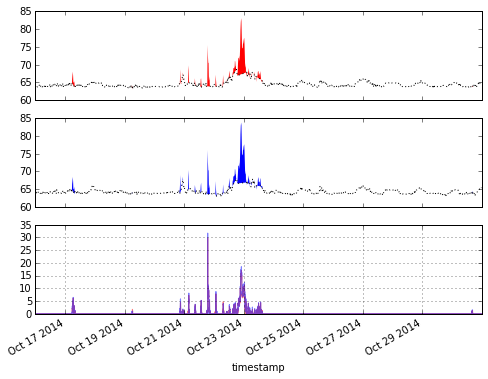

In [15]:
cml.do_baseline_determination(method='linear', wet_external=wet_combi)
cml.calc_A()

### PLOT ###
def plot_baselines():
    fig, ax = subplots(3, 1, figsize=(fig_width,10), sharex=True)
    ax[0].fill_between(cml.data.resample('15min').index, 
                       cml.data.resample('15min').txrx_fn, 
                       cml.data.resample('15min').baseline_fn,
                       edgecolor=None, lw=0.0, facecolor='r')
    ax[0].plot(cml.data.resample('15min').index,
               cml.data.resample('15min').baseline_fn, ':k')

    ax[1].fill_between(cml.data.resample('15min').index, 
                       cml.data.resample('15min').txrx_nf, 
                       cml.data.resample('15min').baseline_nf,
                       edgecolor=None, lw=0.0, facecolor='b')
    ax[1].plot(cml.data.resample('15min').index,
               cml.data.resample('15min').baseline_nf, ':k')

    cml.data.A_fn.plot(figsize=(fig_width,6), color='r', alpha=0.5, ax=ax[2])
    cml.data.A_nf.plot(figsize=(fig_width,6), color='b', alpha=0.5, ax=ax[2]);

plot_baselines()

# Try a constant baseline and adjust for wet antenna attenuation (Schleiss et al, 2013)

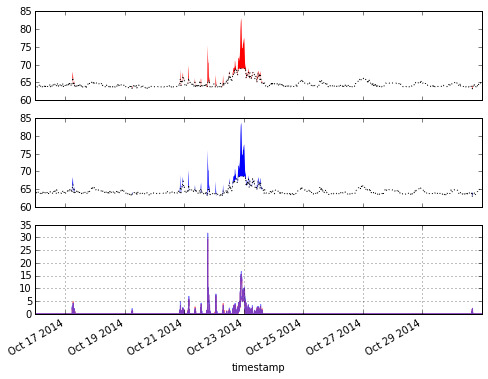

In [16]:
cml.do_baseline_determination(method='constant', wet_external=wet_combi)

cml.do_wet_antenna_baseline_adjust(waa_max=2, 
                                   delta_t=1, 
                                   tau=60, 
                                   wet_external=wet_combi)
cml.calc_A()

plot_baselines()

#import mpld3
#mpld3.display()

# Calculate R from A and plot rainfall depth

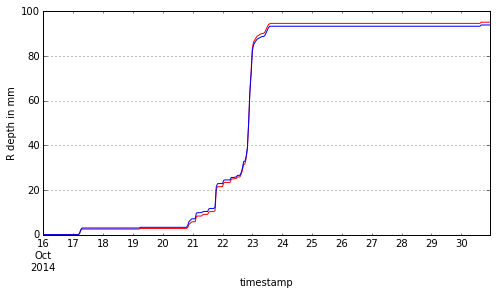

In [17]:
cml.calc_R_from_A()

### PLOT ###
cml.data.R_fn.resample('H').cumsum().plot(color='r');
cml.data.R_nf.resample('H').cumsum().plot(color='b', figsize=(fig_width,4))

ylabel('R depth in mm');

# Test new generic plotting function

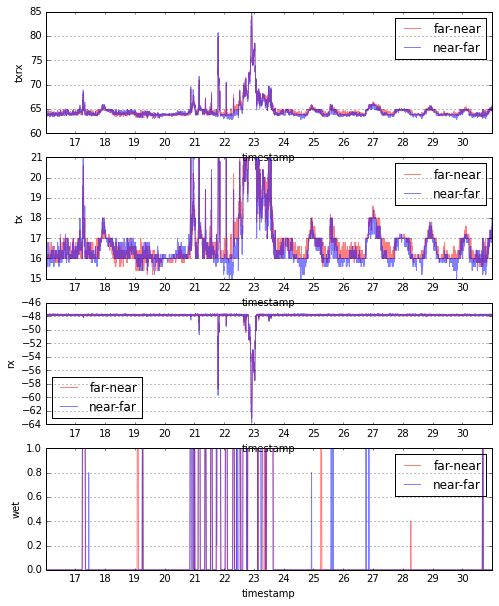

In [18]:
cml.plot(param_list=['txrx', 'tx', 'rx', 'wet'], 
         figsize=(fig_width,10), 
         resampling_time='5min', 
         alpha=0.5);

# And all in one rush

In [19]:
# Load two month of data
cml_id = 'MY0364_2_MY2291_3'
cml = get_cml_data_from_IFU_database(cml_id, '2014-10-16', '2014-12-20')

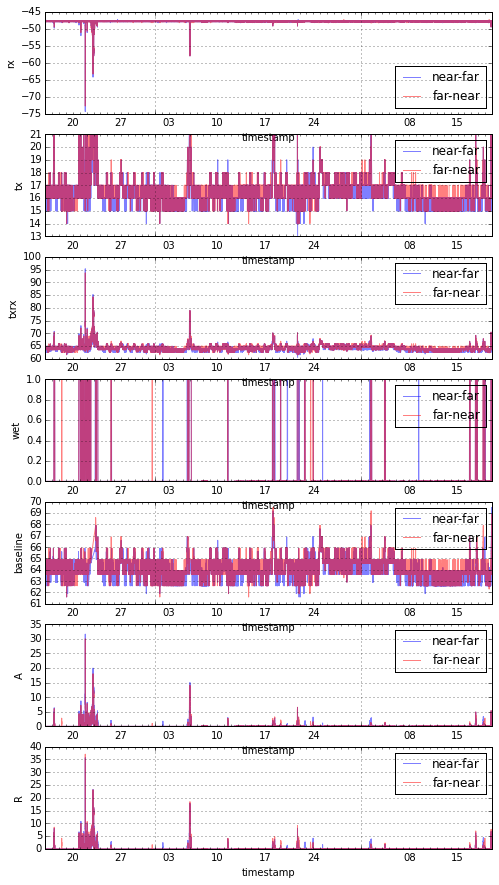

In [20]:
# Do processing
cml.do_wet_dry_classification(method='std_dev', 
                              window_length=100, 
                              threshold=0.7)
cml.do_baseline_determination(method='linear')
cml.calc_A()
cml.calc_R_from_A()

# Plot
cml.plot(param_list=['rx', 'tx', 'txrx', 'wet', 'baseline', 'A', 'R'], 
         figsize=(fig_width,15), 
         resampling_time='min', 
         alpha=0.5);

# And plot the rainfall depth

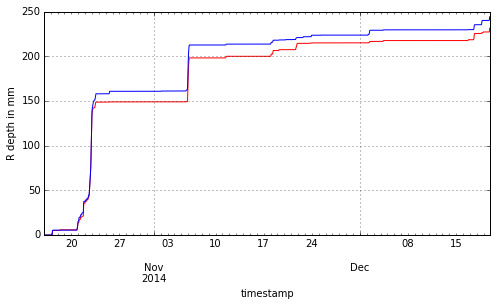

In [21]:
cml.data.R_fn.resample('H').cumsum().plot(color='r');
cml.data.R_nf.resample('H').cumsum().plot(color='b', figsize=(fig_width,4))

ylabel('R depth in mm');